# Import module

In [3]:
# モジュールをインポート
import numpy as np
from numpy import random as rd
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Setup

In [4]:
# 各惑星系におけるパラメータ及び必要な測光制度
fname = '/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Simulation/Primary/Revise'
z = np.load('{}/Data/parameter_3000.npy'.format(fname))
T_star = np.load('{}/Data/temperature.npy'.format(fname)).astype(int)
R_star = np.load('{}/Data/radius.npy'.format(fname))*6.960*10**10
R_planet = R_planet = 6.378137*10**8
P = np.load('{}/Data/period.npy'.format(fname))
a = np.load('{}/Data/semi.npy'.format(fname))
p = R_planet/R_star
t_exp = 60
P_tra = P*R_star/np.pi/a
t_one = (P_tra*3/t_exp).astype(np.int64)

# Data loading

In [5]:
# 波長のリストを取得し、10µmの位置番号を取得
lamb = np.load('{}/Data/lamb.npy'.format(fname))
lamb_10 = np.abs(lamb-10)
l_10 = np.where(lamb_10==lamb_10.min())[0][0]

In [6]:
# 各ピクセルの値を取得
result = 6
D_sci = np.load('{}/Result_{}/D_sci_1.npy'.format(fname, result))
D_back = np.load('{}/Result_{}/D_back_1.npy'.format(fname, result))
D_ref = np.load('{}/Result_{}/D_ref_1.npy'.format(fname, result))
for i in range(2, 5):
    D_sci = np.vstack((D_sci, np.load('{}/Result_{}/D_sci_{}.npy'.format(fname, result, i))))
    D_back = np.vstack((D_back, np.load('{}/Result_{}/D_back_{}.npy'.format(fname, result, i))))
    D_ref = np.vstack((D_ref, np.load('{}/Result_{}/D_ref_{}.npy'.format(fname, result, i))))

In [7]:
# 規格化された各データを取得
result = 4
mod = [np.load('{}/Result_{}/mod_curve_primary_{}.npy'.format(fname, result, temp)) for temp in T_star]
sci = [np.load('{}/Result_{}/sci_curve_primary_{}.npy'.format(fname, result, temp)) for temp in T_star]
wog = [np.load('{}/Result_{}/wog_curve_primary_{}.npy'.format(fname, result, temp)) for temp in T_star]
sub_both = [np.load('{}/Result_{}/sub_both_curve_primary_{}.npy'.format(fname, result, temp)) for temp in T_star]
sub_back = [np.load('{}/Result_{}/sub_back_curve_primary_{}.npy'.format(fname, result, temp)) for temp in T_star]
sub_ref = [np.load('{}/Result_{}/sub_ref_curve_primary_{}.npy'.format(fname, result, temp)) for temp in T_star]

In [8]:
# スペクトルデータと各評価値を取得
df_spectrum = pd.ExcelFile('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Data/planet_spectrum.xlsx').parse('primary')
    
volume_num = 1
n = 100
T_len = 4
lamb_len = len(lamb)
sci_eva = np.array([np.load('{}/Result_{}/sci_evaluation_primary_{}.npy'.format(fname, result, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sci_sig = np.array([np.load('{}/Result_{}/sci_sigma_primary_{}.npy'.format(fname, result, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
wog_eva = np.array([np.load('{}/Result_{}/wog_evaluation_primary_{}.npy'.format(fname, result, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
wog_sig = np.array([np.load('{}/Result_{}/wog_sigma_primary_{}.npy'.format(fname, result, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_both_eva = np.array([np.load('{}/Result_{}/sub_evaluation_both_primary_{}.npy'.format(fname, result, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_both_sig = np.array([np.load('{}/Result_{}/sub_sigma_both_primary_{}.npy'.format(fname, result, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_back_eva = np.array([np.load('{}/Result_{}/sub_evaluation_back_primary_{}.npy'.format(fname, result, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_back_sig = np.array([np.load('{}/Result_{}/sub_sigma_back_primary_{}.npy'.format(fname, result, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_ref_eva = np.array([np.load('{}/Result_{}/sub_evaluation_ref_primary_{}.npy'.format(fname, result, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)
sub_ref_sig = np.array([np.load('{}/Result_{}/sub_sigma_ref_primary_{}.npy'.format(fname, result, i)) for i in range(volume_num)]).reshape(n, T_len, lamb_len)

# Data correction

In [9]:
# 60回分のtransit curveを一つの行に平滑化
sci_flat = np.array([sci[T].reshape(t_one[T]*60) for T in range(4)])
wog_flat = np.array([wog[T].reshape(t_one[T]*60) for T in range(4)])
sub_both_flat = np.array([sub_both[T].reshape(t_one[T]*60) for T in range(4)])
sub_back_flat = np.array([sub_back[T].reshape(t_one[T]*60) for T in range(4)])
sub_ref_flat = np.array([sub_ref[T].reshape(t_one[T]*60) for T in range(4)])

In [10]:
# 60回分のtransit curveをone transitに平均化
sci_bin = np.array([np.mean(sci[T], axis=0) for T in range(4)])
wog_bin = np.array([np.mean(wog[T], axis=0) for T in range(4)])
sub_both_bin = np.array([np.mean(sub_both[T], axis=0) for T in range(4)])
sub_back_bin = np.array([np.mean(sub_back[T], axis=0) for T in range(4)])
sub_ref_bin = np.array([np.mean(sub_ref[T], axis=0) for T in range(4)])

In [11]:
# 系統誤差とランダム誤差をそれぞれの平均値と分散値でガウス分布する値を作成
def Gauss(eva, sig):
    eva_mean = np.mean(eva, axis=0)
    eva_std = np.std(eva, axis=0)
    systematic = rd.normal(eva_mean, eva_std)
    sig_mean = np.mean(sig, axis=0)
    sig_std = np.std(sig, axis=0)
    random = rd.normal(sig_mean, sig_std)
    return systematic, random

sci_sys, sci_rand = Gauss(sci_eva, sci_sig)
wog_sys, wog_rand = Gauss(wog_eva, wog_sig)
sub_both_sys, sub_both_rand = Gauss(sub_both_eva, sub_both_sig)
sub_back_sys, sub_back_rand = Gauss(sub_back_eva, sub_back_sig)
sub_ref_sys, sub_ref_rand = Gauss(sub_ref_eva, sub_ref_sig)

In [12]:
# 各評価値の標準偏差を取得
sci_eva_std = np.std(sci_eva, axis=0)
wog_eva_std = np.std(wog_eva, axis=0)
sub_both_eva_std = np.std(sub_both_eva, axis=0)
sub_back_eva_std = np.std(sub_back_eva, axis=0)
sub_ref_eva_std = np.std(sub_ref_eva, axis=0)

In [13]:
# R=100におけるspectrumを作成
lamb_raw = df_spectrum.wavelength.values
spectrum_raw = np.array([df_spectrum[temp].values for temp in ['2500K', '3000K', '3500K', '4000K']])*10**6
func = [interpolate.interp1d(lamb_raw, spectrum_raw[T], kind='cubic') for T in range(4)]
spectrum = [func[T](lamb) for T in range(4)]

In [14]:
# T=3000K, λ=10µmのデータの規格化
D_sci_mean = D_sci.mean(axis=0)
D_ref_mean = D_ref.mean(axis=0)
top = [D_sci_mean[k] for k in range(len(D_sci_mean)) if z[k]>1+p[1]]
D_sci_norm = D_sci_mean/np.mean(top)
D_ref_norm = D_ref_mean/D_ref_mean.mean()

# Data Explanation

## Smoothed out

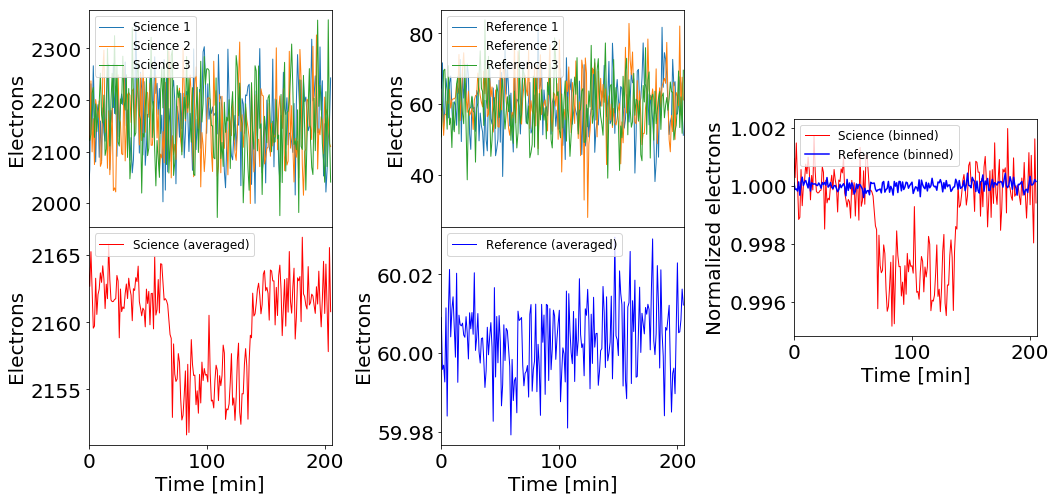

In [16]:
# science pixelとreference pixelで得られるデータのプロット、及びsmooth outの様子を説明したグラフの作成
class SmoothedOut(object):
    
    def __init__(self, i, name, D):
        self.i = i
        self.name = name
        self.D = D
        
    def raw(self):
        plt.subplot(self.i)
        for j in range(3):
            k = rd.choice(np.linspace(1, len(self.D), len(self.D))).astype(int)
            plt.plot(self.D[k], linewidth=1, label='{} {}'.format(self.name, j+1))
        plt.legend(loc='upper left', prop={'size':12})
        plt.xlim(0, len(self.D[0]))
        plt.xticks([])
    
    def binned(self, color):
        plt.subplot(self.i)
        plt.plot(self.D, c=color, linewidth=1, label='{} (averaged)'.format(self.name))
        plt.legend(loc='upper left', prop={'size':12})
        plt.xlim(0, len(self.D))
        
plt.figure(figsize=(17, 8))
plt.rcParams['font.size'] = 20
gs = gridspec.GridSpec(4, 3)
SmoothedOut(gs[:2, 0], 'Science', D_sci).raw()
plt.ylabel('Electrons')
SmoothedOut(gs[:2, 1], 'Reference',D_ref).raw()
plt.ylabel('Electrons')
SmoothedOut(gs[2:, 0], 'Science', D_sci_mean).binned('r')
plt.xlabel('Time [min]')
plt.ylabel('Electrons')
SmoothedOut(gs[2:, 1], 'Reference', D_ref_mean).binned('b')
plt.xlabel('Time [min]')
plt.ylabel('Electrons')
plt.subplot(gs[-3:-1, -1])
plt.plot(D_sci_norm, c='r', linewidth=1, label='Science (binned)')
plt.plot(D_ref_norm, c='b',  label='Reference (binned)')
plt.legend(loc='upper left', prop={'size':12})
plt.xlim(0, len(D_sci_norm))
plt.xlabel('Time [min]')
plt.ylabel('Normalized electrons')
plt.subplots_adjust(hspace=0, wspace=0.45)
plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/smoothed_out.pdf')

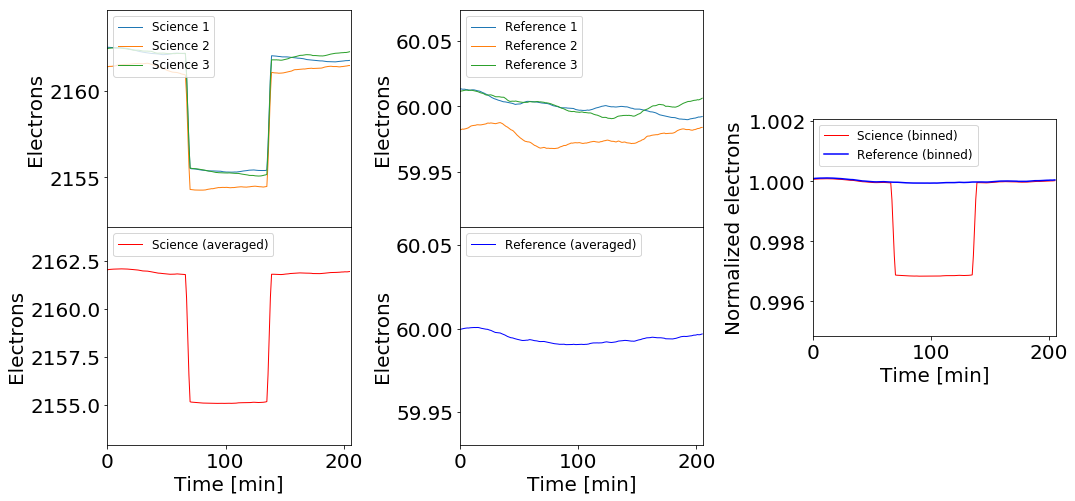

In [69]:
# science pixelとreference pixelで得られるデータのプロット、及びsmooth outの様子を説明したグラフの作成
class SmoothedOut(object):
    
    def __init__(self, i, name, D):
        self.i = i
        self.name = name
        self.D = D
        
    def raw(self):
        D_min = 10000
        D_max = 0
        plt.subplot(self.i)
        for j in range(3):
            k = rd.choice(np.linspace(1, len(self.D), len(self.D))).astype(int)
            plt.plot(self.D[k], linewidth=1, label='{} {}'.format(self.name, j+1))
            D_min_j = self.D.min()
            D_max_j = self.D.max()
            if D_min_j<D_min:
                D_min = D_min_j
            if D_max_j>D_max:
                D_max = D_max_j
        plt.legend(loc='upper left', prop={'size':12})
        plt.xlim(0, len(self.D[0]))
        plt.xticks([])
        plt.ylim(D_min*0.999, D_max*1.001)
    
    def binned(self, color):
        D_min = self.D.min()
        D_max = self.D.max()
        plt.subplot(self.i)
        plt.plot(self.D, c=color, linewidth=1, label='{} (averaged)'.format(self.name))
        plt.legend(loc='upper left', prop={'size':12})
        plt.xlim(0, len(self.D))
        plt.ylim(D_min*0.999, D_max*1.001)
        
plt.figure(figsize=(17, 8))
plt.rcParams['font.size'] = 20
gs = gridspec.GridSpec(4, 3)
SmoothedOut(gs[:2, 0], 'Science', D_sci).raw()
plt.ylabel('Electrons')
SmoothedOut(gs[:2, 1], 'Reference',D_ref).raw()
plt.ylabel('Electrons')
SmoothedOut(gs[2:, 0], 'Science', D_sci_mean).binned('r')
plt.xlabel('Time [min]')
plt.ylabel('Electrons')
SmoothedOut(gs[2:, 1], 'Reference', D_ref_mean).binned('b')
plt.xlabel('Time [min]')
plt.ylabel('Electrons')
D_min = D_sci_norm.min()
D_max = D_sci_norm.max()
plt.subplot(gs[-3:-1, -1])
plt.plot(D_sci_norm, c='r', linewidth=1, label='Science (binned)')
plt.plot(D_ref_norm, c='b',  label='Reference (binned)')
plt.legend(loc='upper left', prop={'size':12})
plt.xlim(0, len(D_sci_norm))
plt.ylim(D_min*0.998, D_max*1.002)
plt.xlabel('Time [min]')
plt.ylabel('Normalized electrons')
plt.subplots_adjust(hspace=0, wspace=0.45)
plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/smoothed_out.pdf')

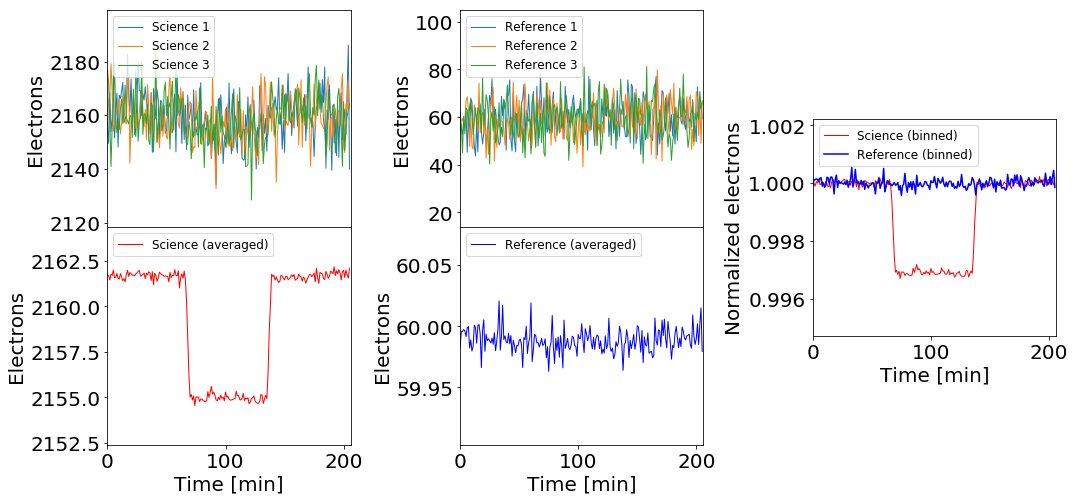

In [72]:
# science pixelとreference pixelで得られるデータのプロット、及びsmooth outの様子を説明したグラフの作成
class SmoothedOut(object):
    
    def __init__(self, i, name, D):
        self.i = i
        self.name = name
        self.D = D
        
    def raw(self):
        D_min = 10000
        D_max = 0
        plt.subplot(self.i)
        for j in range(3):
            k = rd.choice(np.linspace(1, len(self.D), len(self.D))).astype(int)
            plt.plot(self.D[k], linewidth=1, label='{} {}'.format(self.name, j+1))
            D_min_j = self.D.min()
            D_max_j = self.D.max()
            if D_min_j<D_min:
                D_min = D_min_j
            if D_max_j>D_max:
                D_max = D_max_j
        plt.legend(loc='upper left', prop={'size':12})
        plt.xlim(0, len(self.D[0]))
        plt.xticks([])
        plt.ylim(D_min*0.999, D_max*1.001)
    
    def binned(self, color):
        D_min = self.D.min()
        D_max = self.D.max()
        plt.subplot(self.i)
        plt.plot(self.D, c=color, linewidth=1, label='{} (averaged)'.format(self.name))
        plt.legend(loc='upper left', prop={'size':12})
        plt.xlim(0, len(self.D))
        plt.ylim(D_min*0.999, D_max*1.001)
        
plt.figure(figsize=(17, 8))
plt.rcParams['font.size'] = 20
gs = gridspec.GridSpec(4, 3)
SmoothedOut(gs[:2, 0], 'Science', D_sci).raw()
plt.ylabel('Electrons')
SmoothedOut(gs[:2, 1], 'Reference',D_ref).raw()
plt.ylabel('Electrons')
SmoothedOut(gs[2:, 0], 'Science', D_sci_mean).binned('r')
plt.xlabel('Time [min]')
plt.ylabel('Electrons')
SmoothedOut(gs[2:, 1], 'Reference', D_ref_mean).binned('b')
plt.xlabel('Time [min]')
plt.ylabel('Electrons')
D_min = D_sci_norm.min()
D_max = D_sci_norm.max()
plt.subplot(gs[-3:-1, -1])
plt.plot(D_sci_norm, c='r', linewidth=1, label='Science (binned)')
plt.plot(D_ref_norm, c='b',  label='Reference (binned)')
plt.legend(loc='upper left', prop={'size':12})
plt.xlim(0, len(D_sci_norm))
plt.ylim(D_min*0.998, D_max*1.002)
plt.xlabel('Time [min]')
plt.ylabel('Normalized electrons')
plt.subplots_adjust(hspace=0, wspace=0.45)
plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/smoothed_out.pdf')

## Transit curve

In [37]:
# 補正の前後と入力データを示す図を作成
def Curve(i, T, binned=True, sub='ref', model=True, before=True):
    if binned:
        sci = sci_bin[T]
        if sub=='both':
            sub = sub_both_bin[T]
            sub_color = 'c'
        elif sub=='back':
            sub = sub_back_bin[T]
            sub_color = 'g'
        else:
            sub = sub_ref_bin[T]
            sub_color = 'b'
    else:
        sci = sci_flat[T]
        if sub=='both':
            sub = sub_both_flat[T]
            sub_color = 'c'
        elif sub=='back':
            sub = sub_back_flat[T]
            sub_color = 'g'
        else:
            sub = sub_ref_flat[T]
            sub_color = 'b'
    ax = fig.add_subplot(i)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    if before:
        ax.plot(sci, 'ro', c='r', markersize=2)
    ax.plot(sub, 'ro', c=sub_color, markersize=3)
    if model:
        ax.plot(mod[T], c='k')
    ax.set_xlim(0, t_one[T])
    ax.set_xlabel('Time [min]')
    ax.set_ylabel('Normalized flux')
    ax.annotate('{}K'.format(T_star[T]), xy=(0.03, 0.85), xycoords='axes fraction', fontsize=28, ha='left', va='bottom')

In [18]:
## 生データ
"""
sub = 'both'
fig = plt.figure(figsize=(20, 13))
plt.rcParams['font.size'] = 18
Curve(221, 0, binned=False, sub=sub)
plt.ylim(0.985, 1.008)
Curve(222, 1, binned=False, sub=sub)
plt.ylim(0.993, 1.004)
Curve(223, 2, binned=False, sub=sub)
plt.ylim(0.998, 1.002)
Curve(224, 3, binned=False, sub=sub)
plt.ylim(0.9987, 1.0013)
plt.show()
"""

"\nsub = 'both'\nfig = plt.figure(figsize=(20, 13))\nplt.rcParams['font.size'] = 18\nCurve(221, 0, binned=False, sub=sub)\nplt.ylim(0.985, 1.008)\nCurve(222, 1, binned=False, sub=sub)\nplt.ylim(0.993, 1.004)\nCurve(223, 2, binned=False, sub=sub)\nplt.ylim(0.998, 1.002)\nCurve(224, 3, binned=False, sub=sub)\nplt.ylim(0.9987, 1.0013)\nplt.show()\n"

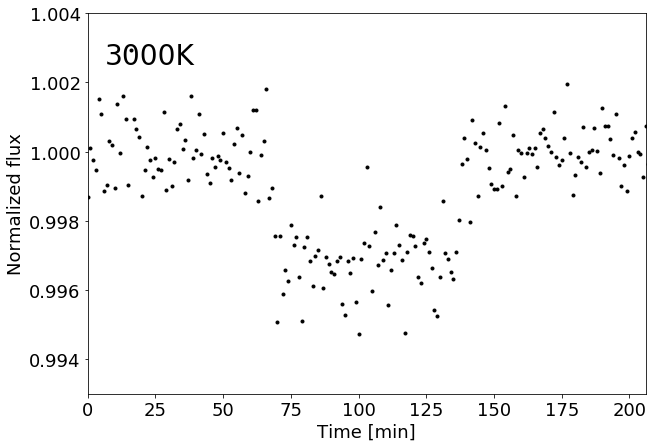

In [36]:
# 生データ
sub = 'both'
fig = plt.figure(figsize=(10, 7))
plt.rcParams['font.size'] = 18
Curve(111, 1, binned=False, sub=sub, model=False, before=False)
plt.ylim(0.993, 1.004)
plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/transit_curve.pdf')
plt.show()

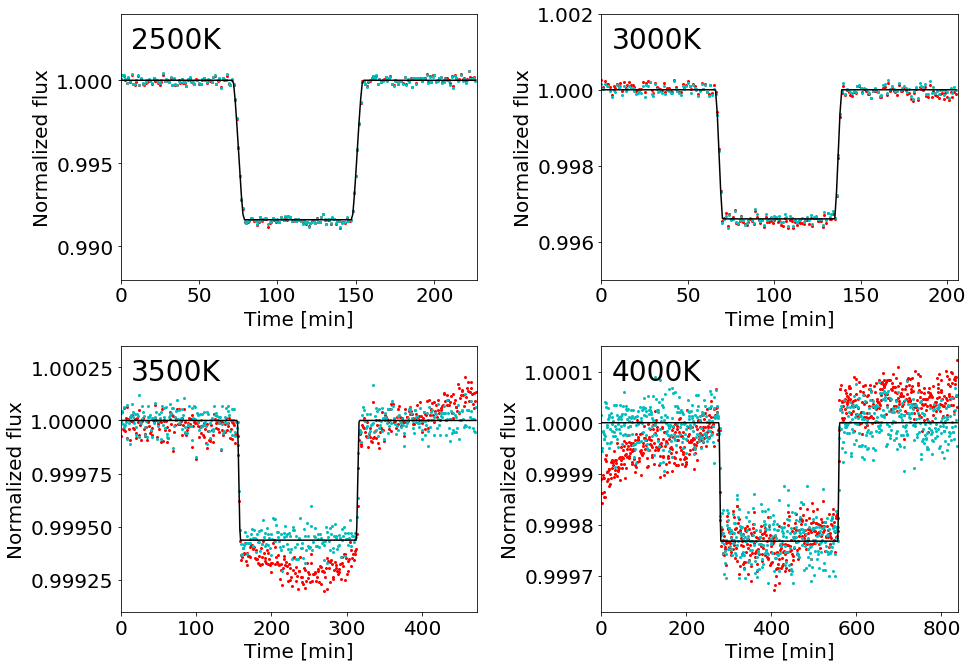

In [19]:
# 60回分のトランジットデータを平均したデータ(both)
fig = plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 20
Curve(221, 0, sub='both')
plt.ylim(0.988, 1.004)
Curve(222, 1, sub='both')
plt.ylim(0.995, 1.002)
Curve(223, 2, sub='both')
plt.ylim(0.9991, 1.00035)
Curve(224, 3, sub='both')
plt.ylim(0.99963, 1.00015)
plt.subplots_adjust(hspace=0.25, wspace=0.35)
plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/transit_curve.pdf')
plt.show()

## Transit histogram

In [20]:
# 補正の前後と系統誤差なしの信号のヒストグラム及び真値を示す図を作成
def Histgram(i, T, binned=True, sub='ref'):
    if binned:
        sci = sci_bin[T]
        wog = wog_bin[T]
        if sub=='both':
            sub = sub_both_bin[T]
            sub_color = 'c'
        elif sub=='back':
            sub = sub_back_bin[T]
            sub_color = 'g'
        else:
            sub = sub_ref_bin[T]
            sub_color = 'b'
    else:
        sci = sci_flat[T]
        wog = wog_flat[T]
        if sub=='both':
            sub = sub_both_flat[T]
            sub_color = 'c'
        elif sub=='back':
            sub = sub_back_flat[T]
            sub_color = 'g'
        else:
            sub = sub_ref_flat[T]
            sub_color = 'b'
    ax = fig.add_subplot(i)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.hist(sci, bins=70, color='r', normed=True, alpha=0.6)
    ax.hist(sub, bins=70, color=sub_color, normed=True, alpha=0.6)
    ax.hist(wog, bins=70, color='y', normed=True, alpha=0.6)
    ax.axvline(x=mod[T][int(len(mod[T])/2)], color='k')
    ax.axvline(x=mod[T][0], color='k')
    ax.set_xlabel('Normalized flux')
    ax.set_ylabel('Count')
    ax.annotate('{}K'.format(T_star[T]), xy=(0.03, 0.85), xycoords='axes fraction', fontsize=28, ha='left', va='bottom')

In [21]:
## トランジット60回分のデータ
#fig = plt.figure(figsize=(17, 13))
#plt.rcParams['font.size'] = 18
#Histgram(221, 0, binned=False)
#Histgram(222, 1, binned=False)
#Histgram(223, 2, binned=False)
#plt.xlim(0.994, 1.005)
#Histgram(224, 3, binned=False)
#plt.xticks([0.996, 1, 1.004])
#plt.show()

/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


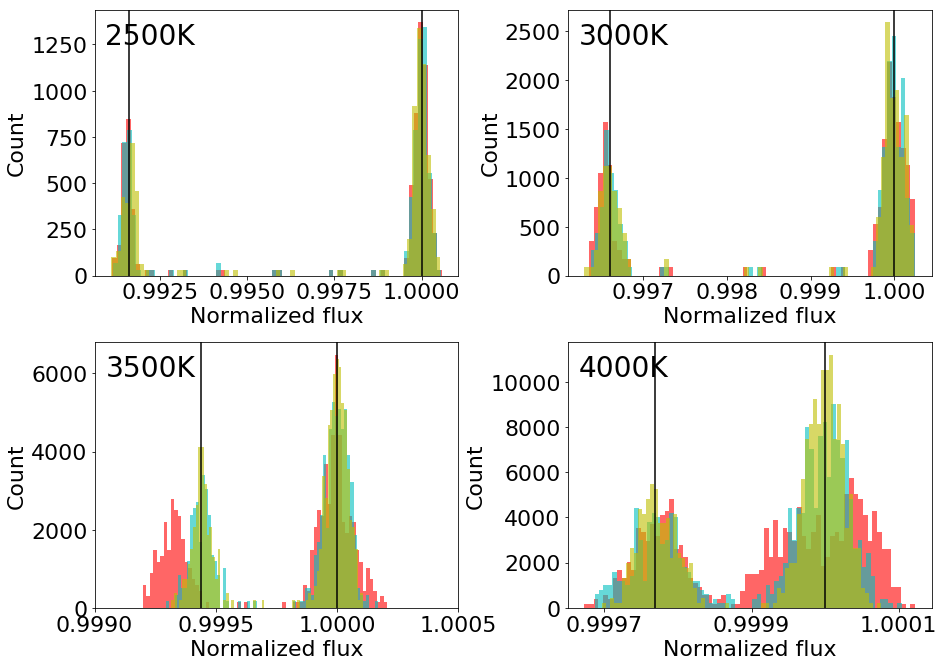

In [22]:
# 60回分のトランジットデータを平均したデータ(both)
fig = plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
Histgram(221, 0, sub='both')
Histgram(222, 1, sub='both')
plt.xticks([0.997, 0.998, 0.999, 1])
Histgram(223, 2, sub='both')
plt.xticks([0.999, 0.9995, 1, 1.0005])
Histgram(224, 3, sub='both')
plt.xticks([0.9997, 0.9999, 1.0001])
plt.subplots_adjust(wspace=0.3, hspace=0.25)
plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/histogram_binned.pdf')
plt.show()

## Systematic error with 100 iterataions

In [23]:
## 100回イテレーションした結果のsystematic errorの分布
def SysHist(eva):
    x = np.linspace(eva.mean()-150, eva.mean()+150, 100000)
    y = np.exp(-(x-eva.mean())**2/(2*eva.std()**2))/(np.sqrt(2*np.pi)*eva.std())
    plt.figure(figsize=(10,7))
    plt.hist(eva, bins=10, normed=True)
    plt.plot(x, y)
    plt.xlabel('Systematic error [ppm]')
    plt.ylabel('Count')
    
#λ = 66
#print(lamb[λ])
#SysHist(sub_eva[:, 1, λ])
#print(np.std(sub_eva[:, 1, λ]))

In [45]:
mean = sub_both_eva[:, 1, l_10].mean()
std = sub_both_eva[:, 1, l_10].std()
print('mean:', mean)
print(' std:', std)

mean: -3.447580106621384
 std: 15.642306220754628


In [15]:
# systematic errorの分布（100回イテレーション）
def SystematicError(i, T, sub='ref'):
    sci = sci_eva[:, T]
    if sub=='both':
        sub = sub_both_eva[:, T]
        sub_color = 'c'
    elif sub=='back':
        sub = sub_back_eva[:, T]
        sub_color = 'g'
    else:
        sub = sub_ref_eva[:, T]
        sub_color = 'b'
    ymax = np.abs(sci).max()+70
    ax = fig.add_subplot(i)
    for j in range(100):
        ax.scatter(lamb, sci[j], c='r', s=8)
        ax.scatter(lamb, sub[j], c=sub_color, s=8)
    ax.set_xlabel('Wavelength [µm]')
    ax.set_ylabel('ppm')
    ax.set_xlim(lamb[0], lamb[-1])
    ax.set_ylim(-ymax, ymax)
    ax.annotate('{}K'.format(T_star[T]), xy=(0.03, 0.85), xycoords='axes fraction', fontsize=28, ha='left', va='bottom')

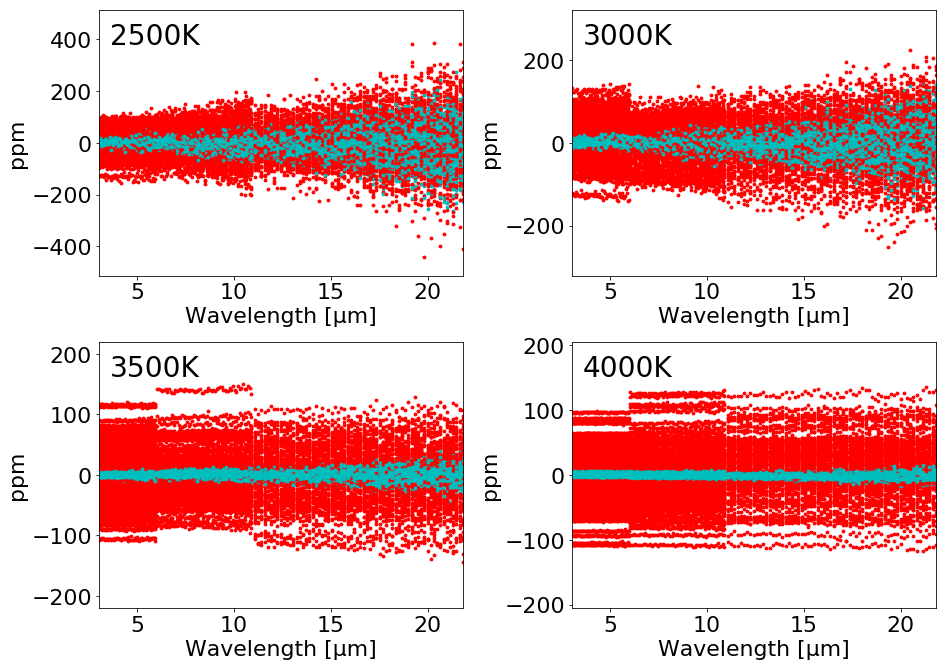

In [16]:
# both
fig = plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
SystematicError(221, 0, sub='both')
SystematicError(222, 1, sub='both')
SystematicError(223, 2, sub='both')
SystematicError(224, 3, sub='both')
plt.subplots_adjust(hspace=0.25, wspace=0.3)
#plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/systematic_error.pdf')
plt.show()

## Systematic error

In [17]:
# 系統誤差とランダム誤差を示す図を作成
def Evaluation(i, T, ylim_min, ylim_max, text=True, text_pos=False):
    std_markersize = 2
    rand_markersize = 4
    ax = fig.add_subplot(i)
    #ax.plot(lamb, abs(wog_eva_std[T]), 'ro', c='g', markersize=std_markersize)
    ax.plot(lamb, abs(sci_eva_std[T]), 'ro', c='r', markersize=std_markersize)
    ax.plot(lamb, abs(sub_both_eva_std[T]), 'ro', c='c', markersize=std_markersize)
    ax.plot(lamb, abs(sub_back_eva_std[T]), 'ro', c='g', markersize=std_markersize)
    ax.plot(lamb, abs(sub_ref_eva_std[T]), 'ro', c='b', markersize=std_markersize)
    ax.plot(lamb, abs(wog_rand[T]), 'x', c='r', markersize=rand_markersize)
    #ax.plot(lamb, abs(sci_rand[T]), 'x', c='r', markersize=rand_markersize)
    ax.plot(lamb, abs(sub_both_rand[T]), 'x', c='c', markersize=rand_markersize)
    ax.plot(lamb, abs(sub_back_rand[T]), 'x', c='g', markersize=rand_markersize)
    ax.plot(lamb, abs(sub_ref_rand[T]), 'x', c='b', markersize=rand_markersize)
    ax.set_xlabel('Wavelength [μm]')
    ax.set_ylabel('ppm')
    ax.set_xlim(lamb[0], lamb[-1])
    ax.set_ylim(ylim_min, ylim_max)
    if text:
        if text_pos:
            ax.annotate('{}K'.format(T_star[T]), xy=(0.03, 0.7), xycoords='axes fraction', fontsize=28, ha='left', va='bottom')
        else:
            ax.annotate('{}K'.format(T_star[T]), xy=(0.03, 0.85), xycoords='axes fraction', fontsize=28, ha='left', va='bottom')

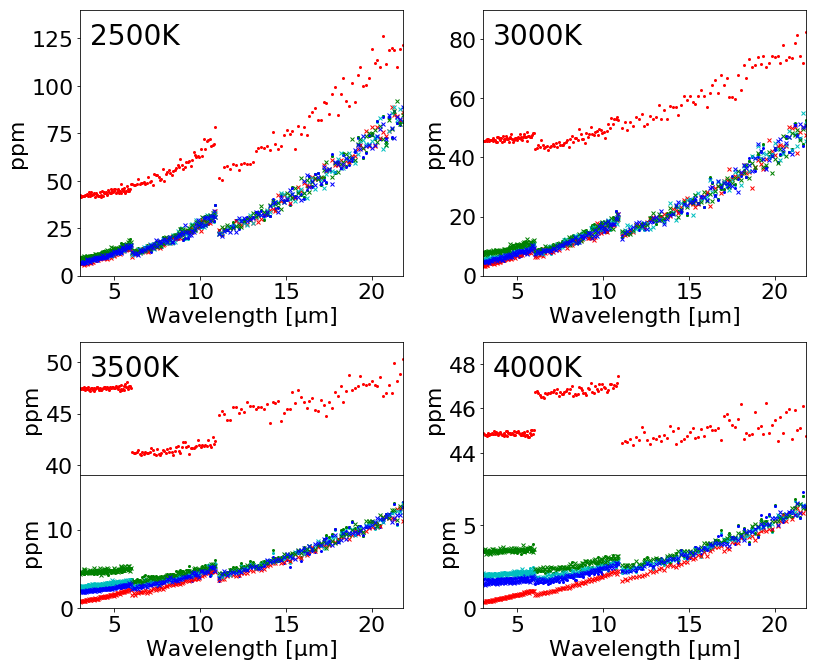

In [18]:
# R=100
fig = plt.figure(figsize=(13, 11))
plt.rcParams['font.size']=22
gs = gridspec.GridSpec(9, 2)
Evaluation(gs[0:4, 0], 0, 0, 140)
Evaluation(gs[0:4, 1], 1, 0, 90)
Evaluation(gs[5:7, 0], 2, 39, 52, text_pos=True)
plt.xticks([])
Evaluation(gs[7:9, 0], 2, 0, 17, text=False)
Evaluation(gs[5:7, 1], 3, 43, 49, text_pos=True)
plt.xticks([])
Evaluation(gs[7:9, 1], 3, 0, 8, text=False)
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/systematic_evaluation_primary.pdf')
plt.show()

## Spectram

In [19]:
# 地球大気の吸収スペクトルに補正後のデータを載せた図を作成
def Spectrum(i, T, sub='both', lamb_range='all', x_min=3, x_max=22, y_min=None, y_max=None):
    if sub=='both':
        sub_eva = sub_both_eva[:, T]
        sub_sig = sub_both_sig[:, T]
    elif sub=='back':
        sub_eva = sub_back_eva[:, T]
        sub_sig = sub_back_sig[:, T]
    else:
        sub_eva = sub_ref_eva[:, T]
        sub_sig = sub_ref_sig[:, T]
    x = lamb
    y = spectrum[T]
    y_sys = sub_eva[rd.choice(np.arange(100))]
    y_err = sub_sig[rd.choice(np.arange(100))]
    sys_error = y+y_sys
    ax = fig.add_subplot(i)
    ax.plot(x, y, c='r', linewidth=2.0)
    ax.plot(x, sys_error, 'ro', c='g', markersize=3.0)
    ax.errorbar(x, sys_error, yerr=y_err, fmt='ro', markersize=0.0, ecolor='k')
    ax.set_xlabel('Wavelength [μm]')
    ax.set_ylabel('Transit depth [ppm]')
    ax.set_xlim(x_min, x_max)
    if lamb_range=='all':
        ax.text(4, CO2_1[T], '$\it{CO_{2}}$', color='c')
        ax.annotate('$\it{CH_{4}}$', color='c', xy=(7.7, CH4_arrow[T]), xytext=(6.5, CH4[T]),
                    arrowprops=dict(arrowstyle='wedge', facecolor='c', edgecolor='c'))
        ax.text(10, O3[T], '$\it{O_{3}}$', color='c')
        ax.text(12.5, CO2_2[T], '$\it{CO_{2}}$', color='c')
    else:
        ax.set_ylim(y_min, y_max)
        ax.text(3.2, CH4[T], '$\it{CH_{4}}$', color='c')
        ax.text(3.8, CO2[T], '$\it{CO_{2}}$', color='c')
        ax.text(4.8, O3[T], '$\it{O_{3}}$', color='c')
    ax.annotate('{}K'.format(T_star[T]), xy=(0.03, 0.85), xycoords='axes fraction', fontsize=28, ha='left', va='bottom')

92


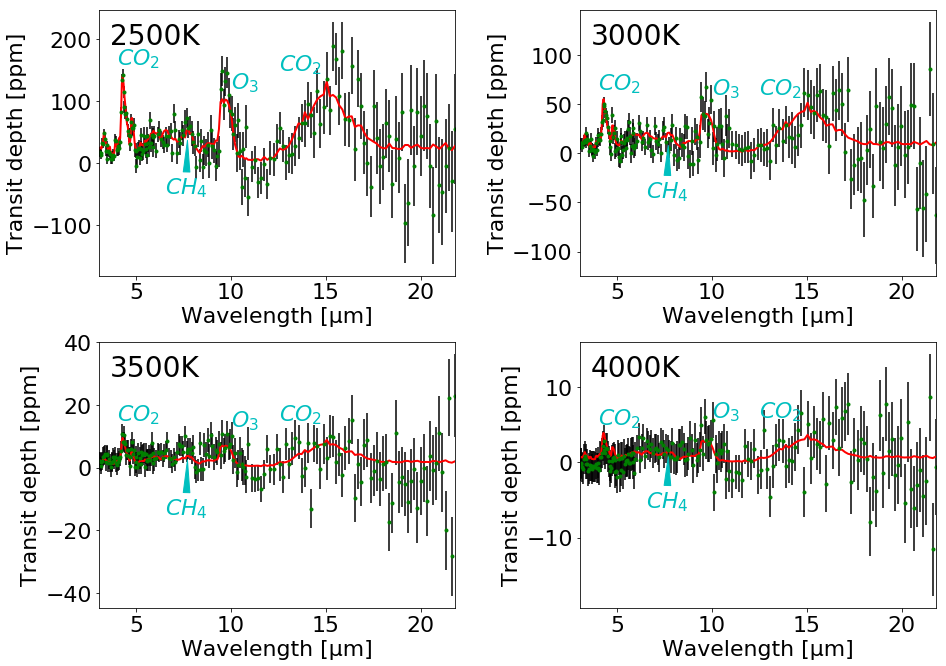

In [20]:
# R=100(all)
random = rd.randint(100)
print(random)
sub = 'both'
CO2_1 = [160, 65, 15, 5]
CH4 = [-50, -45, -15, -6]
CH4_arrow = [40, 10, 3, 1]
O3 = [120, 60, 13, 6]
CO2_2 = [150, 60, 15, 6]
fig = plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
rd.seed(22)
Spectrum(221, 0, sub=sub)
rd.seed(64)
Spectrum(222, 1, sub=sub)
rd.seed(95)
Spectrum(223, 2, sub=sub)
rd.seed(54)
Spectrum(224, 3, sub=sub)
plt.subplots_adjust(hspace=0.25, wspace=0.35)
#plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/spectrum_primary.pdf')
plt.show()

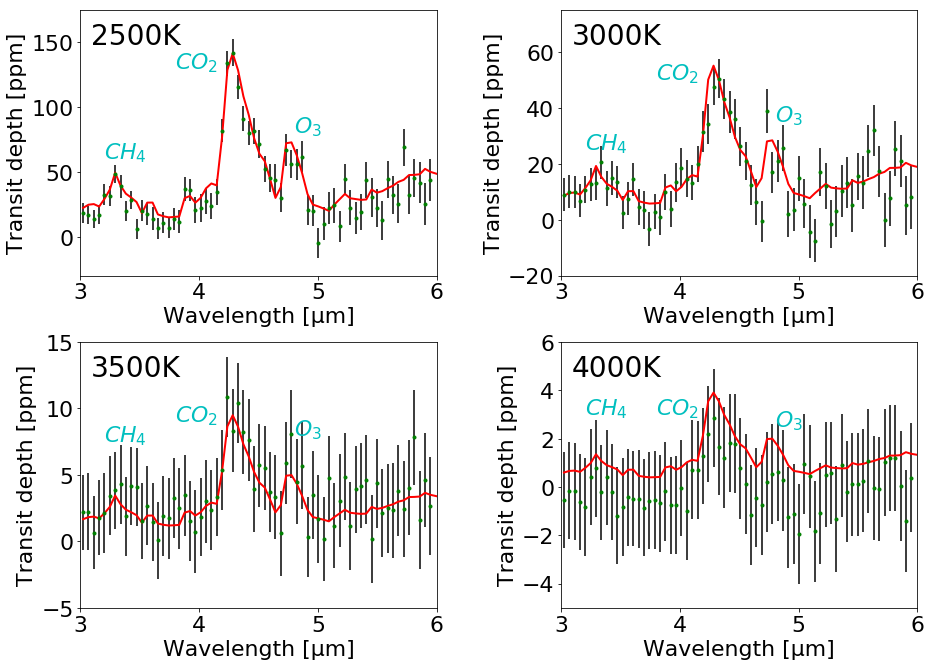

In [22]:
# R=100(short)
sub = 'both'
lamb_range = 'short'
CH4 = [60, 25, 7.5, 3]
CO2 = [130, 50, 9, 3]
O3 = [80, 35, 8, 2.5]
fig = plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
rd.seed(22)
Spectrum(221, 0, sub=sub, lamb_range=lamb_range, x_min=3, x_max=6, y_min=-30, y_max=175)
rd.seed(64)
Spectrum(222, 1, sub=sub, lamb_range=lamb_range, x_min=3, x_max=6, y_min=-20, y_max=75)
rd.seed(95)
Spectrum(223, 2, sub=sub, lamb_range=lamb_range, x_min=3, x_max=6, y_min=-5, y_max=15)
rd.seed(54)
Spectrum(224, 3, sub=sub, lamb_range=lamb_range, x_min=3, x_max=6, y_min=-5, y_max=6)
plt.subplots_adjust(hspace=0.25, wspace=0.35)
plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/spectrum_primary_short.pdf')
plt.show()